# Predicting the Severity of LBP

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost
from xgboost import XGBClassifier


## 1. Data Wrangling

In [2]:
#Load data
df=pd.read_csv('/Users/nirathikeerthi/Desktop/Springboard/Capstone 3 - LBP/LBP_data.csv')

In [3]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant No.        60 non-null     int64  
 1   Gender                 60 non-null     object 
 2   Age                    60 non-null     int64  
 3   Height                 60 non-null     int64  
 4   Weight                 60 non-null     int64  
 5   BMI                    60 non-null     float64
 6   Ethnicity              60 non-null     object 
 7   History                60 non-null     object 
 8   Physical_activity      60 non-null     int64  
 9   Alcohol                60 non-null     int64  
 10  Smoking                60 non-null     int64  
 11  Hours/day              60 non-null     object 
 12  Years                  54 non-null     float64
 13  Occ_Score              60 non-null     int64  
 14  Posture                60 non-null     int64  
 15  Force   

In [4]:
df.drop(columns='Participant No.', inplace=True)

In [5]:
# No. of rows and columns
df.shape

(60, 28)

In [6]:
#visualize
df.head()

,Gender,Age,Height,Weight,BMI,Ethnicity,History,Physical_activity,Alcohol,Smoking,...,JCQ_Score,Decision_Latitude,Physical_Demands,Psychological_Demands,Social_Support,Organizational_Level,Job_Satisfaction,Job_Security,ODI_Score,VAS
0,F,37,62,162,29.626951,Caucasian,Yes,1,1,1,...,162.000000,78,5,8,38,34,0.000000,-1,30,10.00
1,M,72,64,184,31.580078,Caucasian,Yes,4,2,3,...,183.100000,70,10,8,31,61,0.100000,3,70,10.00
2,F,56,65,168,27.953609,Caucasian,No,1,2,3,...,152.566667,66,16,6,33,30,0.566667,1,94,9.84
3,F,60,65,218,36.273136,Black,No,6,3,4,...,172.566667,72,19,16,30,29,0.566667,6,44,8.27
4,M,38,72,209,28.342400,Caucasian,No,1,3,1,...,145.000000,74,10,2,30,28,0.000000,1,40,7.01


In [7]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    6
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         1
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [8]:
#Checking for missing values
df.isin(['?']).sum(axis=0)

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [9]:
# Calculate average ODI and VAS by History and sort by the average of the two
history_means = df.groupby('History')[['ODI_Score', 'VAS']].mean()
history_means.head()

,ODI_Score,VAS
History,,
No,38.750000,8.095417
Yes,43.222222,7.738333


In [10]:
# Calculate average ODI and VAS by Gender and sort by the average of the two
gender_means = df.groupby('Gender')[['ODI_Score', 'VAS']].mean()
gender_means.head()

,ODI_Score,VAS
Gender,,
F,41.352941,7.929706
M,41.538462,7.817692


In [11]:
# Calculate average ODI and VAS by Ethnicity and sort by the average of the two
ethnicity_means = df.groupby('Ethnicity')[['ODI_Score', 'VAS']].mean()
ethnicity_means.head()

,ODI_Score,VAS
Ethnicity,,
Black,43.444444,7.134444
Caucasian,41.641026,8.157179
Other,26.666667,8.773333


In [12]:
df['Ethnicity'].value_counts()

Caucasian    39
Black        18
Other         3
Name: Ethnicity, dtype: int64

In [13]:
# Calculate average ODI and VAS by Hours/day and sort by the average of the two
hours_means = df.groupby('Hours/day')[['ODI_Score', 'VAS']].mean()
hours_means.head()

,ODI_Score,VAS
Hours/day,,
10,42.363636,8.528182
11,16.000000,8.280000
12,42.857143,8.228571
16,56.000000,4.170000
2,48.000000,8.130000


In [14]:
df['Hours/day'].value_counts()

8      22
10     11
12      7
6       4
5       4
9       4
4       2
>8      1
>8      1
16      1
2       1
11      1
7       1
Name: Hours/day, dtype: int64

In [15]:
df.replace('>8 ','99',inplace=True)

In [19]:
df['Hours/day'].value_counts()

8     22
10    11
12     7
6      4
5      4
9      4
4      2
99     1
>8     1
16     1
2      1
11     1
7      1
Name: Hours/day, dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 60 non-null     object 
 1   Age                    60 non-null     int64  
 2   Height                 60 non-null     int64  
 3   Weight                 60 non-null     int64  
 4   BMI                    60 non-null     float64
 5   Ethnicity              60 non-null     object 
 6   History                60 non-null     object 
 7   Physical_activity      60 non-null     int64  
 8   Alcohol                60 non-null     int64  
 9   Smoking                60 non-null     int64  
 10  Hours/day              60 non-null     object 
 11  Years                  54 non-null     float64
 12  Occ_Score              60 non-null     int64  
 13  Posture                60 non-null     int64  
 14  Force                  60 non-null     int64  
 15  Repetiti

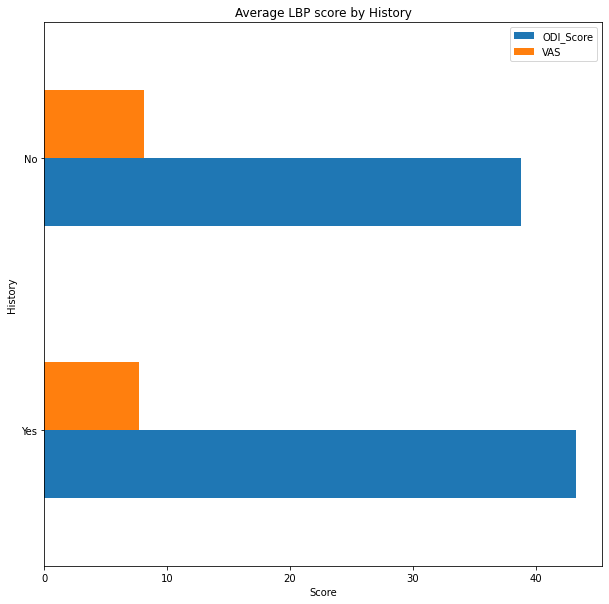

In [22]:
(history_means.reindex(index=history_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average LBP score by History'))
plt.xlabel('Score');

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,60.0,47.083333,16.172053,20.000000,33.000000,48.000000,57.25000,83.000000
Height,60.0,67.033333,3.875025,59.000000,64.000000,66.000000,70.00000,75.000000
Weight,60.0,184.533333,37.726252,95.000000,160.000000,180.000000,211.25000,275.000000
BMI,60.0,28.859479,5.348535,16.826657,25.807846,28.233276,31.65558,42.126754
Physical_activity,60.0,2.533333,1.599435,1.000000,1.000000,3.000000,4.00000,6.000000
Alcohol,60.0,1.750000,0.772954,1.000000,1.000000,2.000000,2.00000,3.000000
Smoking,60.0,1.600000,1.028410,1.000000,1.000000,1.000000,2.00000,5.000000
Years,54.0,12.722222,10.901647,1.000000,4.000000,10.000000,20.00000,50.000000
Occ_Score,60.0,12.283333,6.279079,3.000000,6.000000,12.000000,17.25000,27.000000
Posture,60.0,6.300000,1.985541,3.000000,5.000000,6.000000,8.00000,10.000000


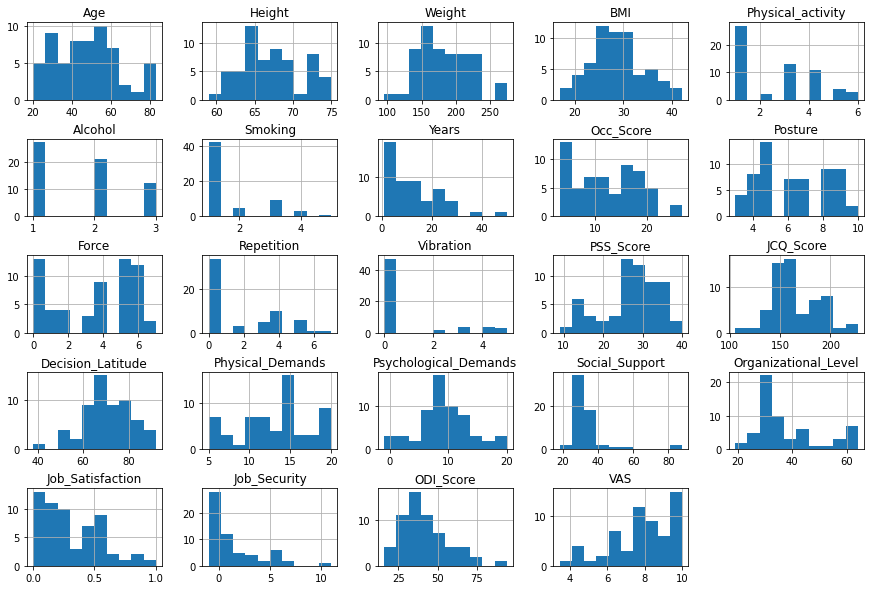

In [24]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [25]:
df['Years'].value_counts()

1.0     5
2.0     5
10.0    4
4.0     4
3.0     3
22.0    3
15.0    3
30.0    3
20.0    3
11.0    2
25.0    2
13.0    2
5.0     2
12.0    2
7.0     2
9.0     1
21.0    1
26.0    1
40.0    1
24.0    1
16.0    1
6.0     1
50.0    1
8.0     1
Name: Years, dtype: int64

In [26]:
df=df.fillna(df.median())

In [27]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

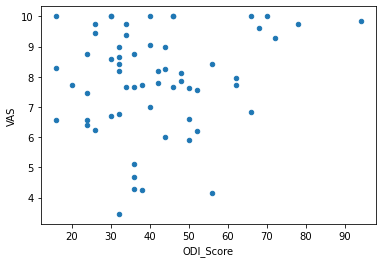

In [28]:
# Target Feature
df.plot(x='ODI_Score', y='VAS', kind='scatter');

In [29]:
df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [30]:
df['VAS'].value_counts()

10.00    8
9.76     3
7.66     3
6.56     2
7.72     2
8.43     2
4.17     1
7.48     1
7.56     1
9.45     1
6.61     1
8.67     1
5.12     1
6.25     1
9.29     1
6.85     1
7.64     1
4.69     1
7.01     1
7.97     1
8.75     1
7.79     1
4.30     1
8.98     1
9.00     1
6.69     1
6.02     1
3.46     1
6.77     1
9.06     1
7.73     1
8.19     1
6.22     1
8.13     1
8.28     1
8.74     1
8.59     1
8.20     1
5.91     1
9.61     1
4.25     1
8.27     1
7.87     1
9.37     1
6.41     1
9.84     1
Name: VAS, dtype: int64

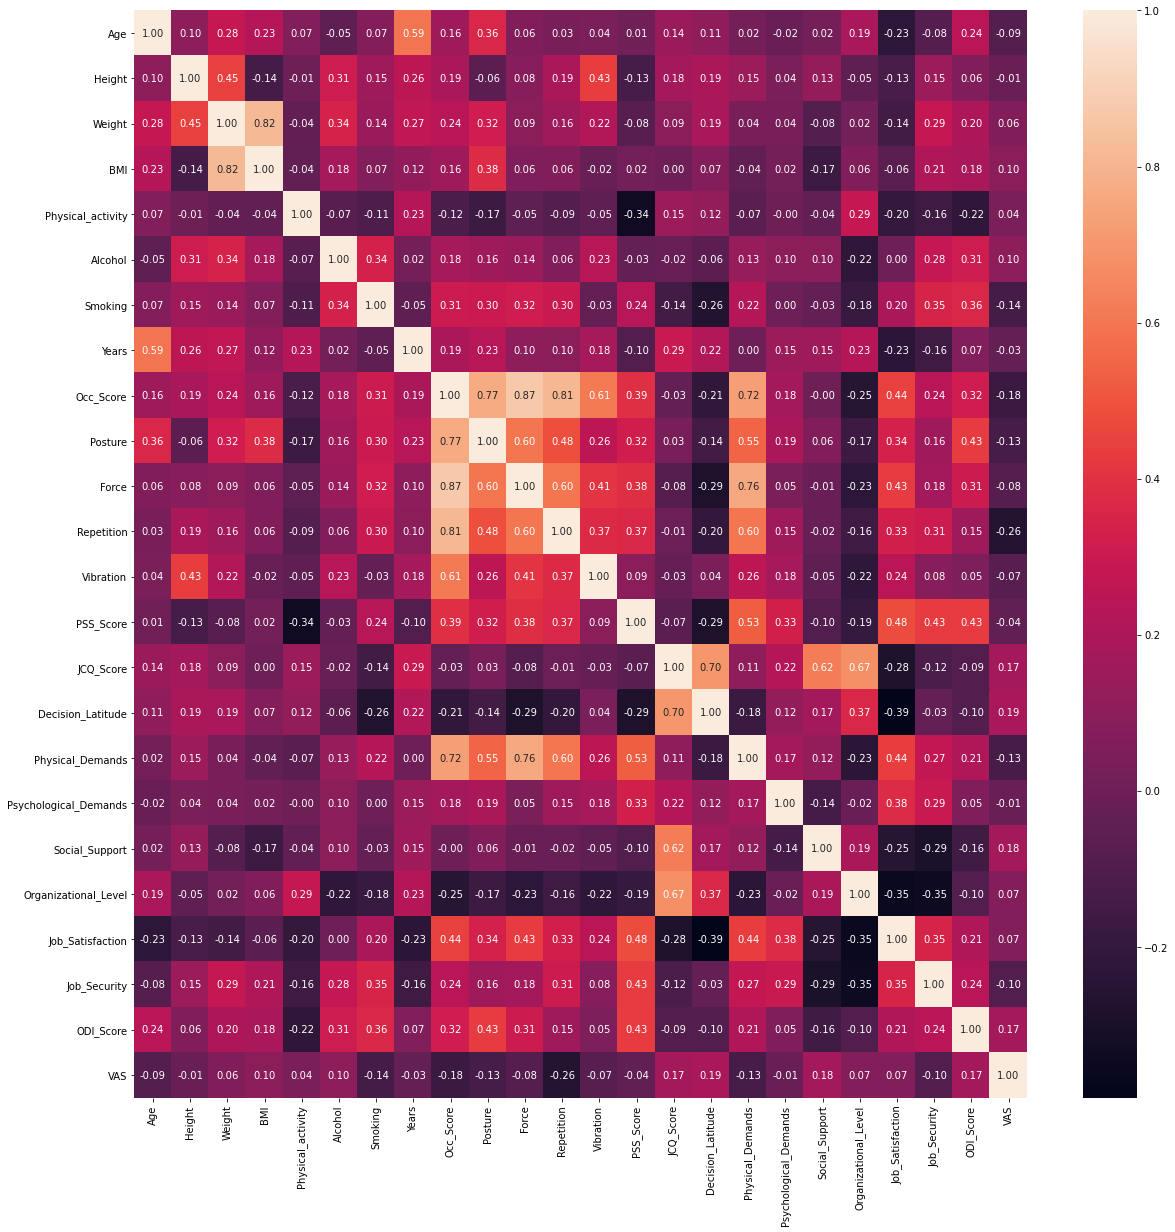

In [31]:
#Visualize correlation of the target variable with other features
plt.subplots(figsize=(20,20))

corr = df.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

## 2. EDA

In [32]:
#Scatter Plots
# define useful function to create scatterplots against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ODI_Score', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='ODI_Score')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [33]:
features = [column for column in df.columns if column not in ['Gender', 'History', 'Ethnicity', 'VAS', 'ODI_Score']]

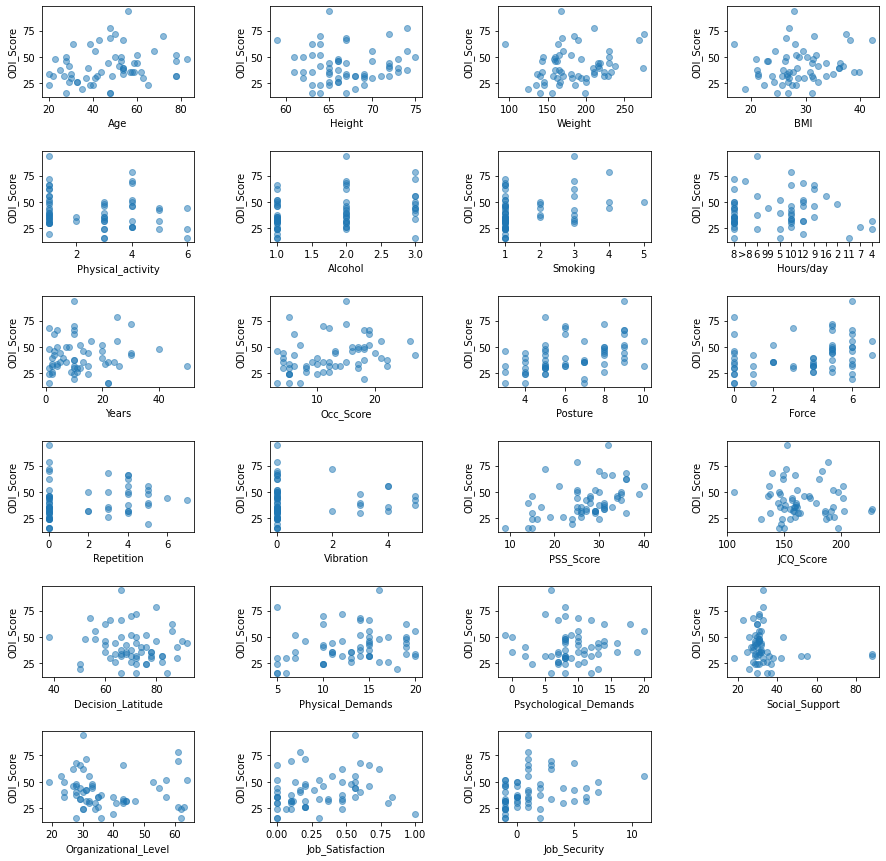

In [34]:
scatterplots(features, ncol=4, figsize=(15, 15))

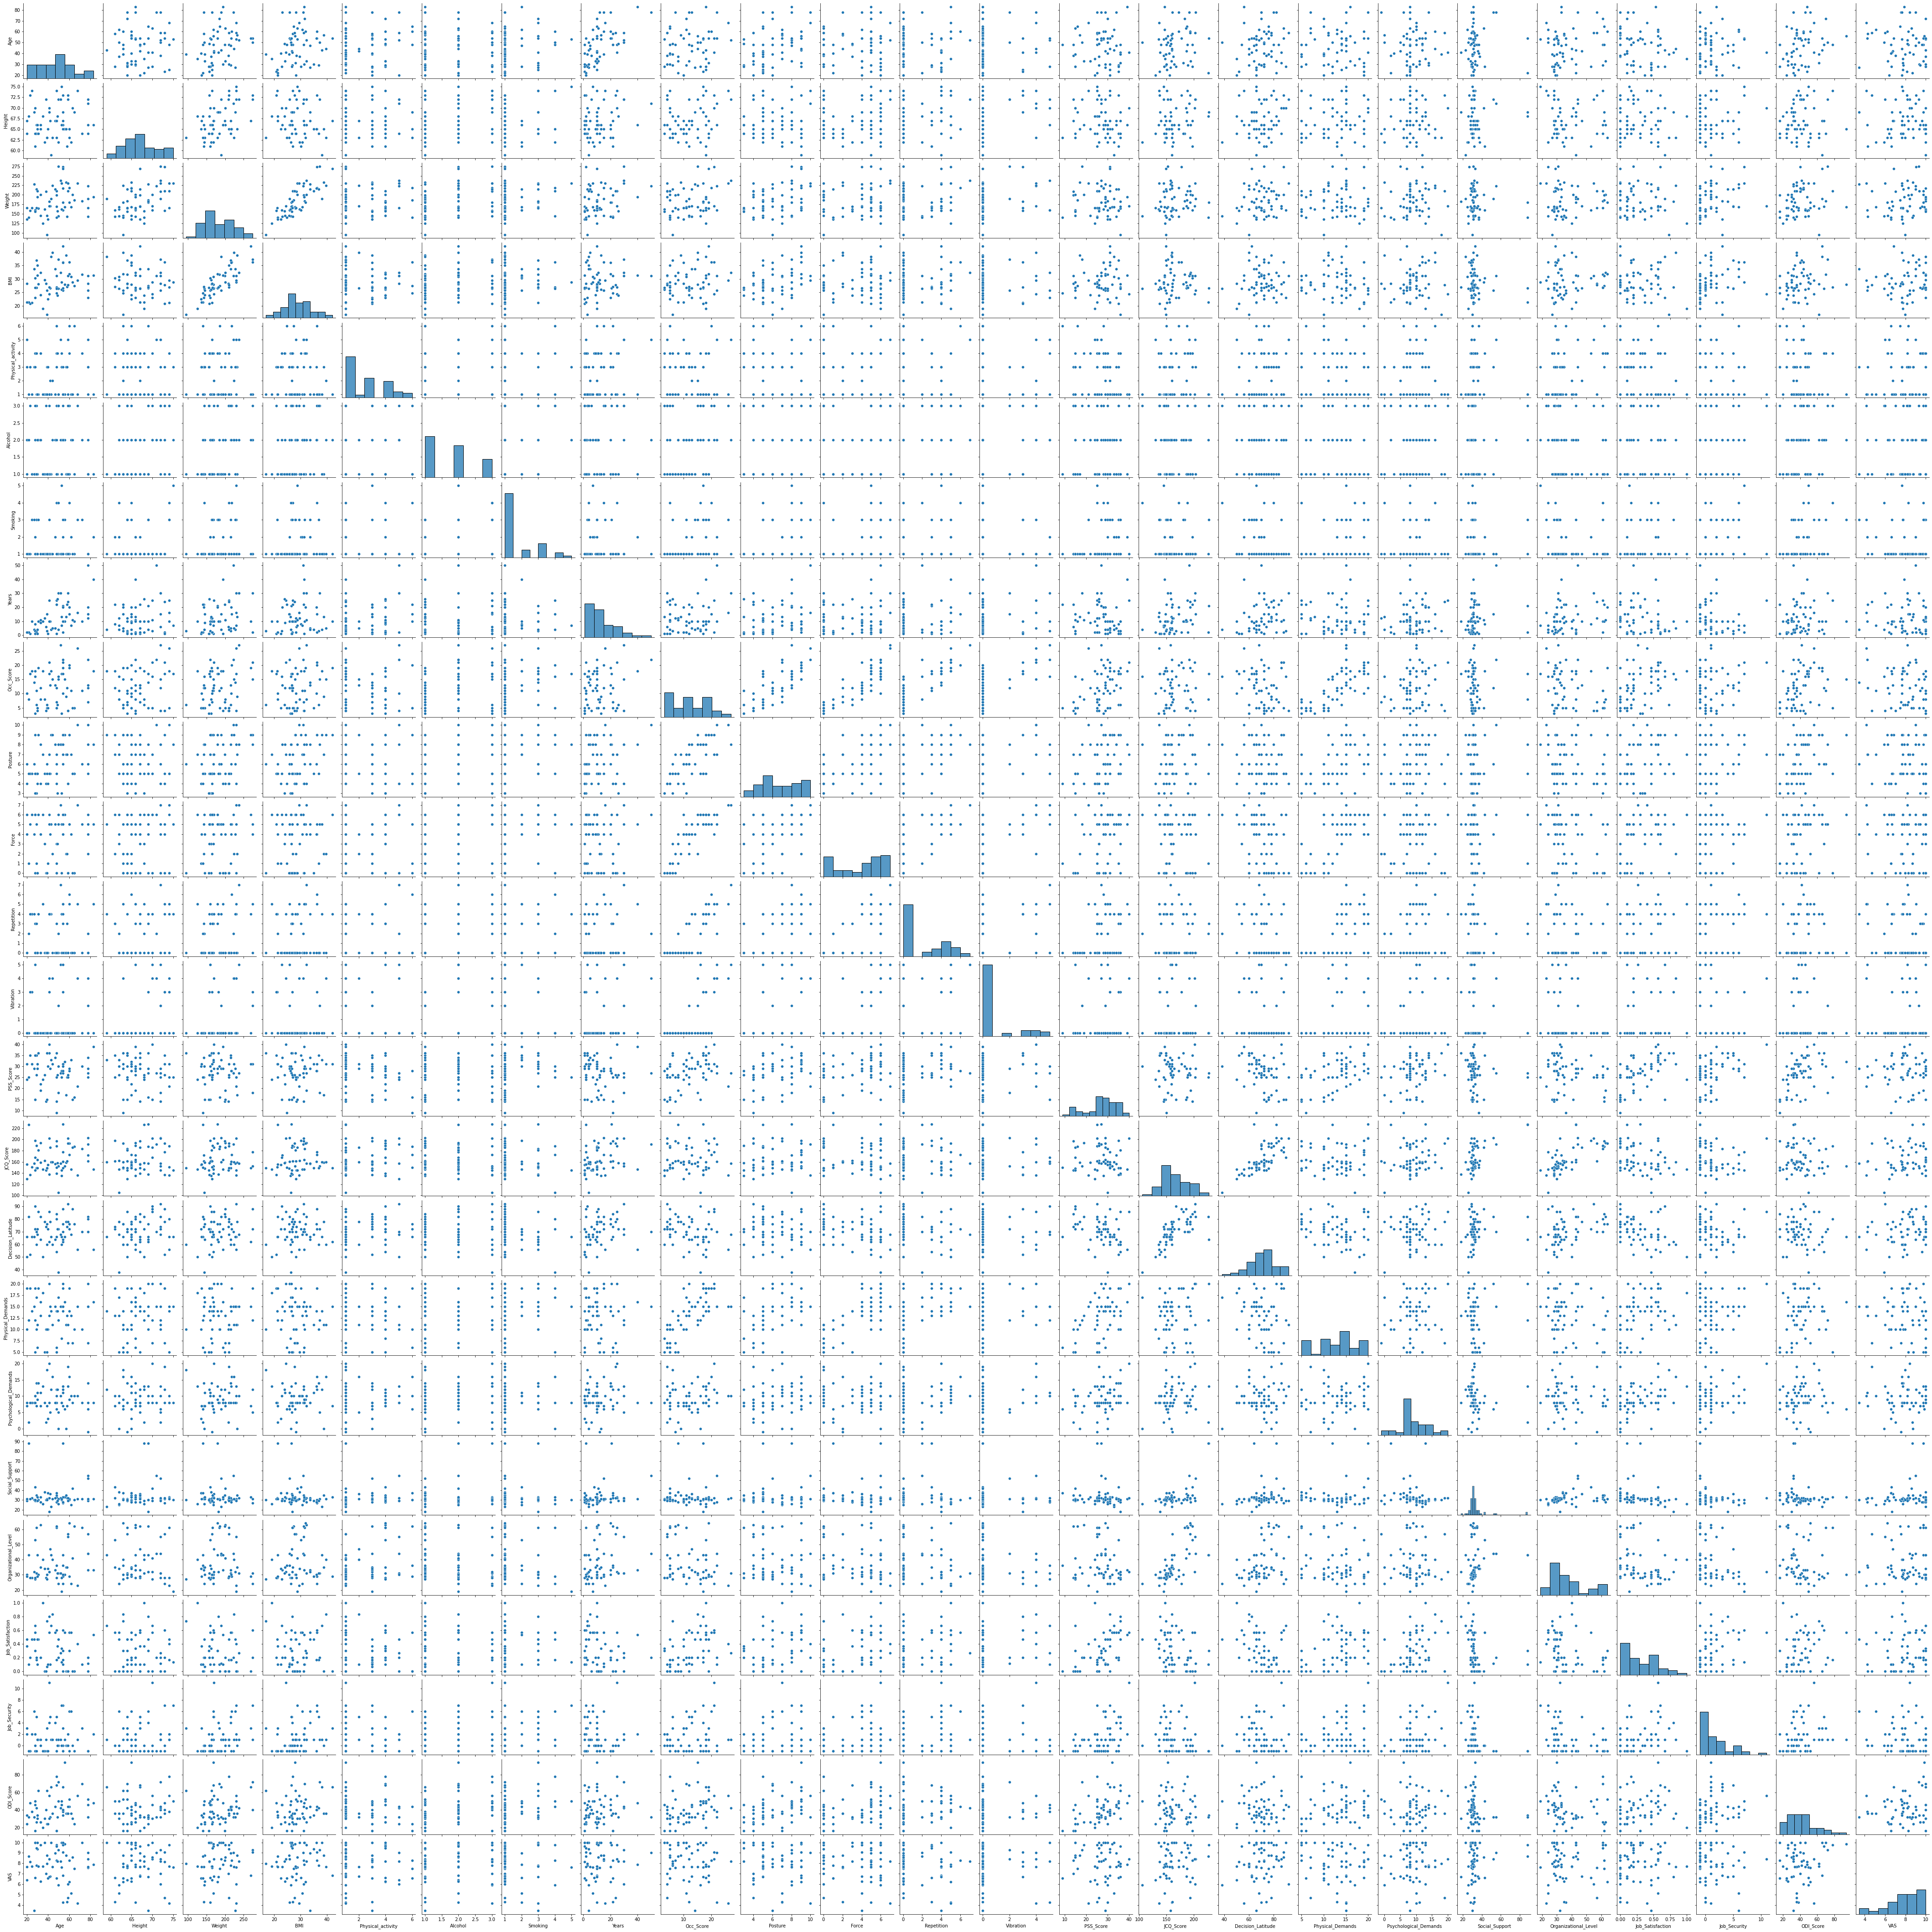

In [35]:
# Make a pairplot of the data
sns.pairplot(df)

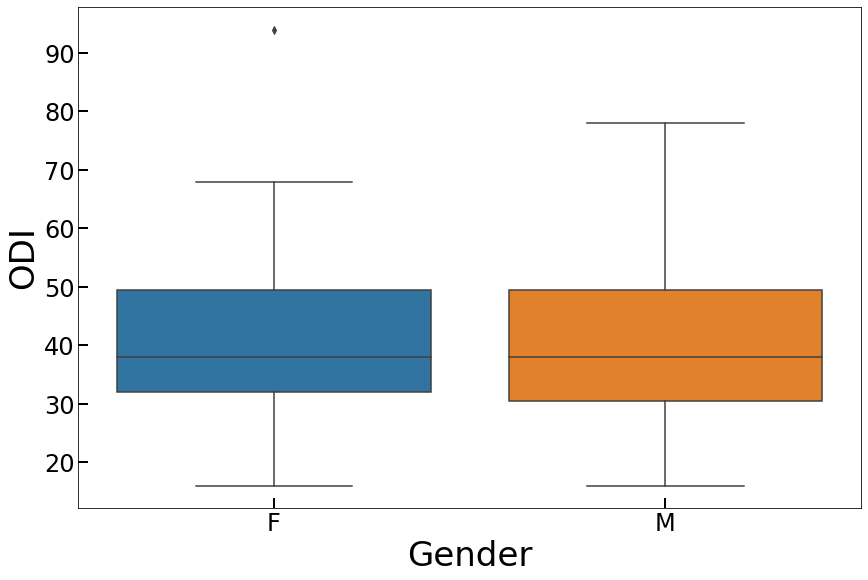

Median value Gender
F    38
M    38
Name: ODI_Score, dtype: int64


In [36]:
# Use the boxplot() method to see if Gender has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='ODI_Score',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['ODI_Score'].median()
print("Median value", Gender_median)


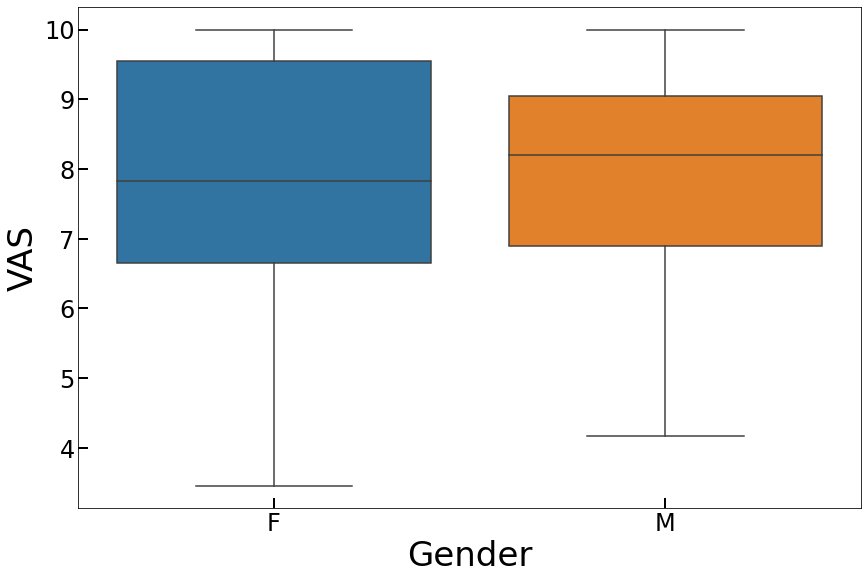

Median value Gender
F    7.830
M    8.195
Name: VAS, dtype: float64


In [37]:
# Use the boxplot() method to see if Gender has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='VAS',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['VAS'].median()
print("Median value", Gender_median)

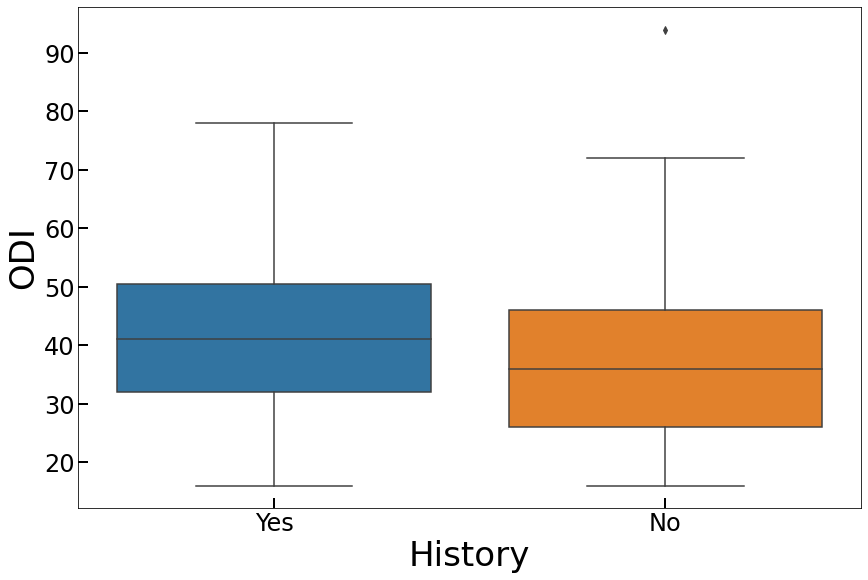

Median value History
No     36
Yes    41
Name: ODI_Score, dtype: int64


In [38]:
# Use the boxplot() method to see if Family history has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='ODI_Score',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['ODI_Score'].median()
print("Median value", Gender_median)

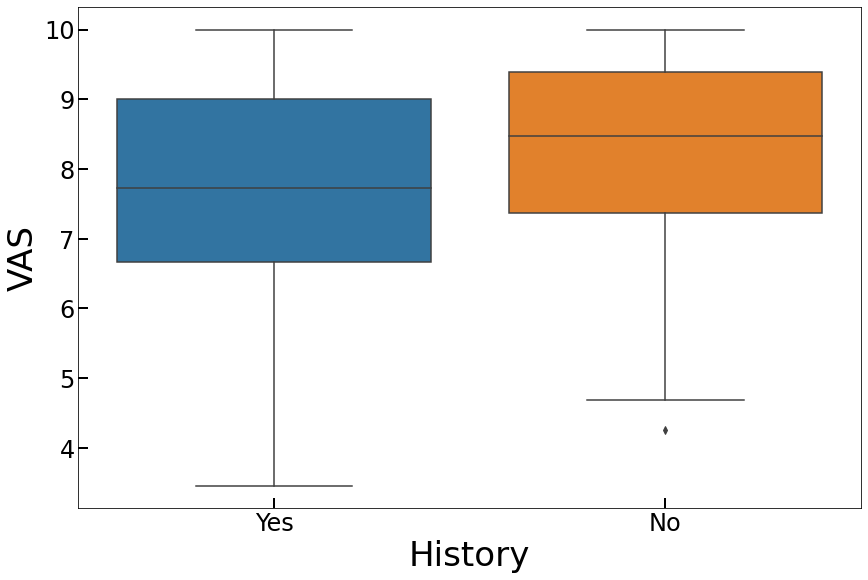

Median value History
No     8.475
Yes    7.725
Name: VAS, dtype: float64


In [39]:
# Use the boxplot() method to see if Family history has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='VAS',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['VAS'].median()
print("Median value", Gender_median)

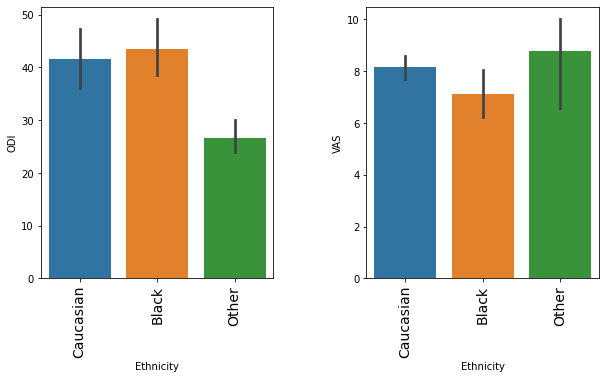

In [40]:
# Check Ethnicity
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Ethnicity", y="ODI_Score", data=df,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='ODI')
#g1.set(xlabel=None)
g2=sns.barplot(x="Ethnicity", y="VAS", data=df,ax=ax[1])
g2.set_xticklabels (g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='VAS')
plt.subplots_adjust(wspace=0.4)

plt.show()

In [41]:
#Create dataframe with only personal factors
personal_df = df[['Gender','Age','Height', 'Weight', 'BMI', 'Ethnicity', 'History', 'Physical_activity', 'Alcohol', 'Smoking']]

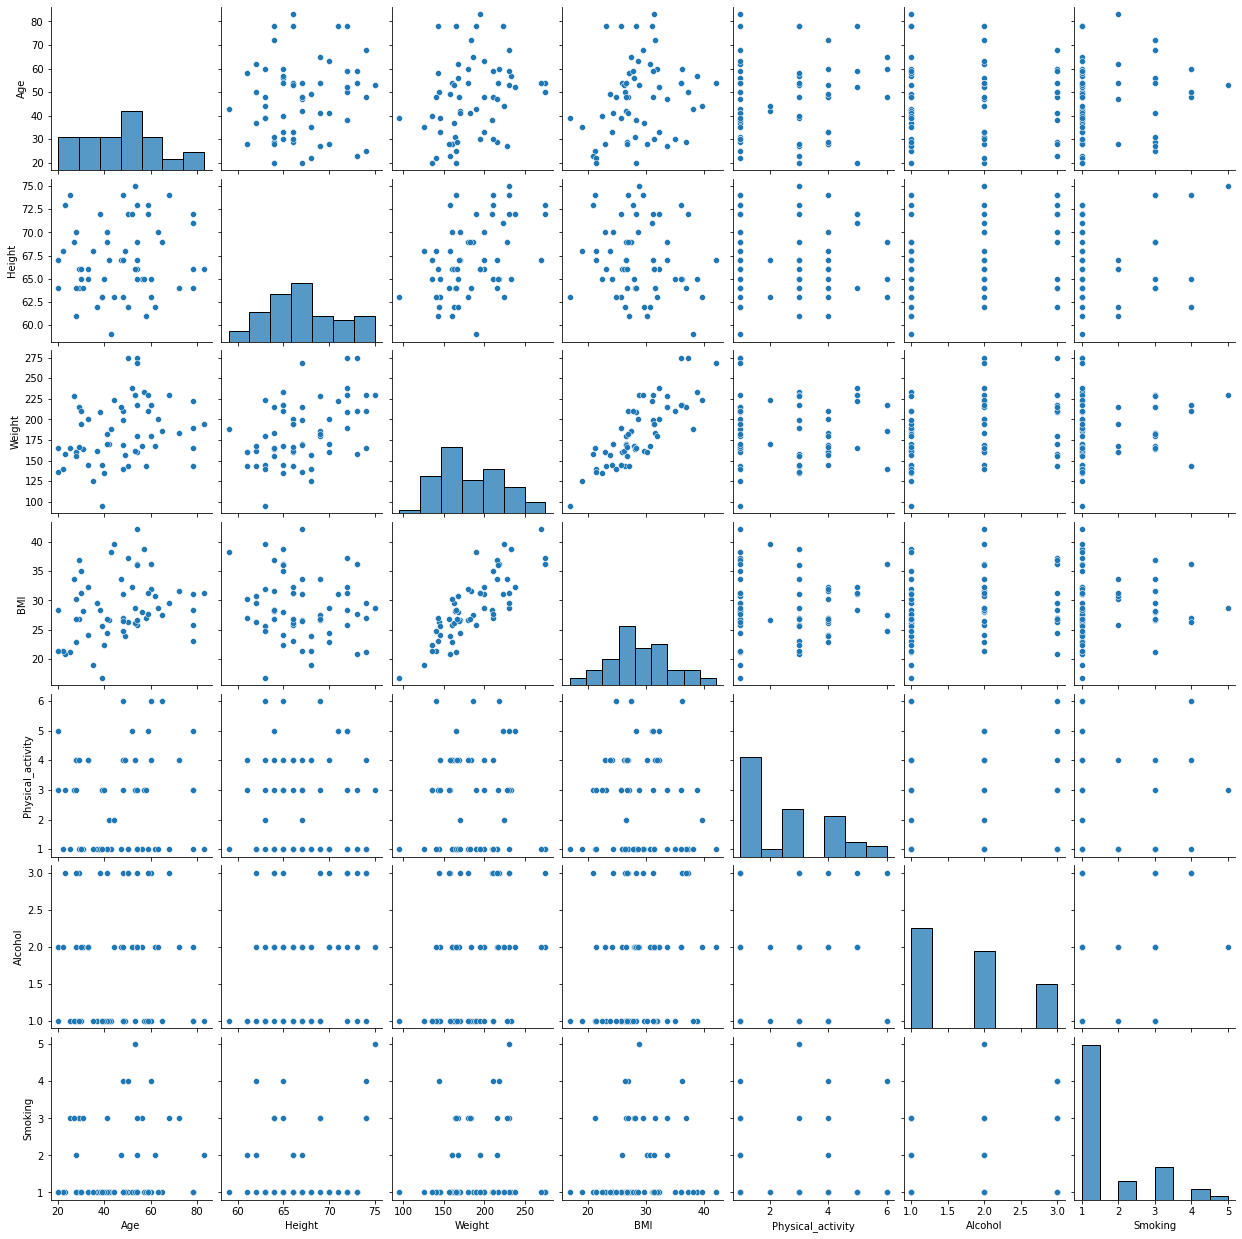

In [42]:
# Make a pairplot of the data
sns.pairplot(personal_df)

In [43]:
#Create dataframe with only occupational factors
occ_df = df[['Hours/day','Years','Occ_Score', 'Posture', 'Force', 'Repetition', 'Vibration']]

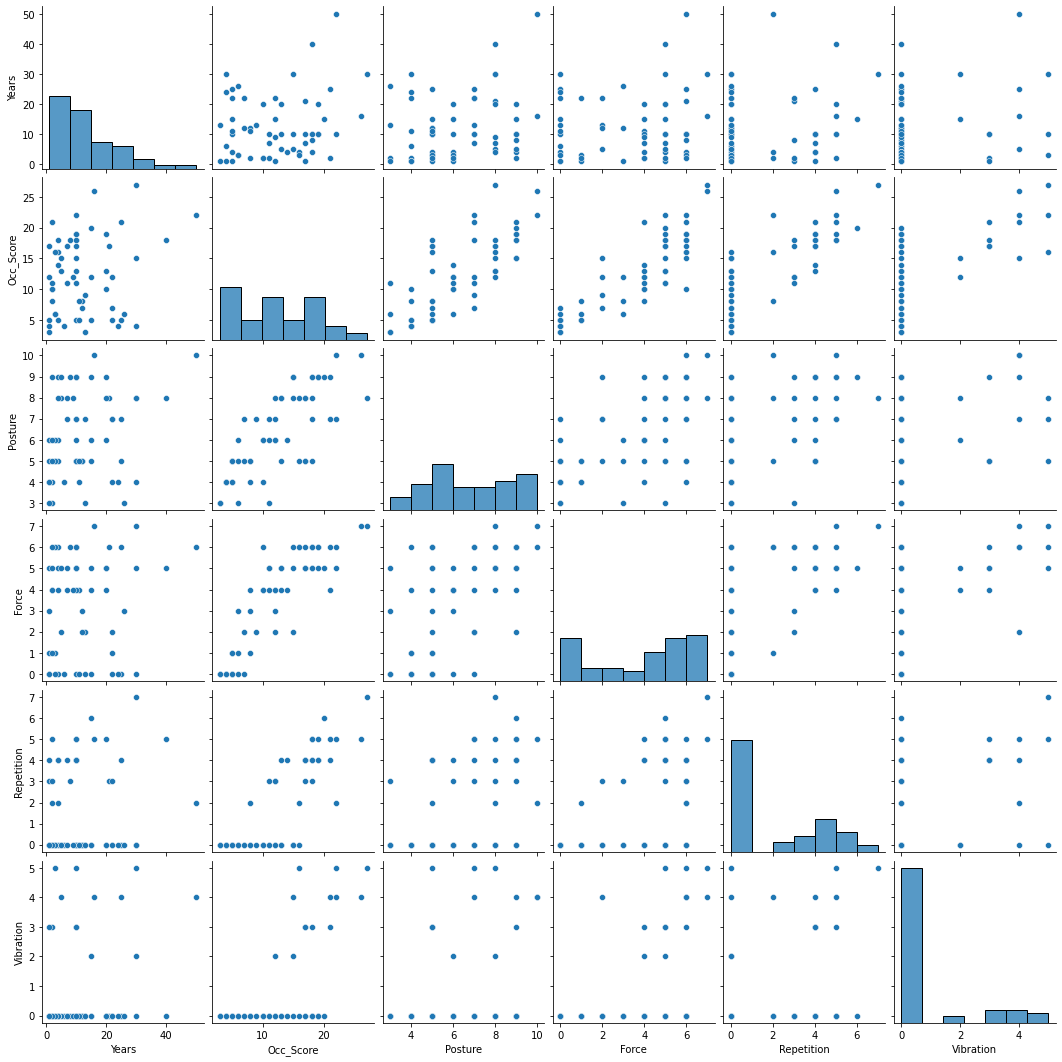

In [44]:
# Make a pairplot of the data
sns.pairplot(occ_df)

In [45]:
#Create dataframe with only psychosocial factors
psy_df = df[['PSS_Score','JCQ_Score','Decision_Latitude', 'Physical_Demands', 'Psychological_Demands', 'Social_Support', 'Organizational_Level', 'Job_Satisfaction', 'Job_Security']]

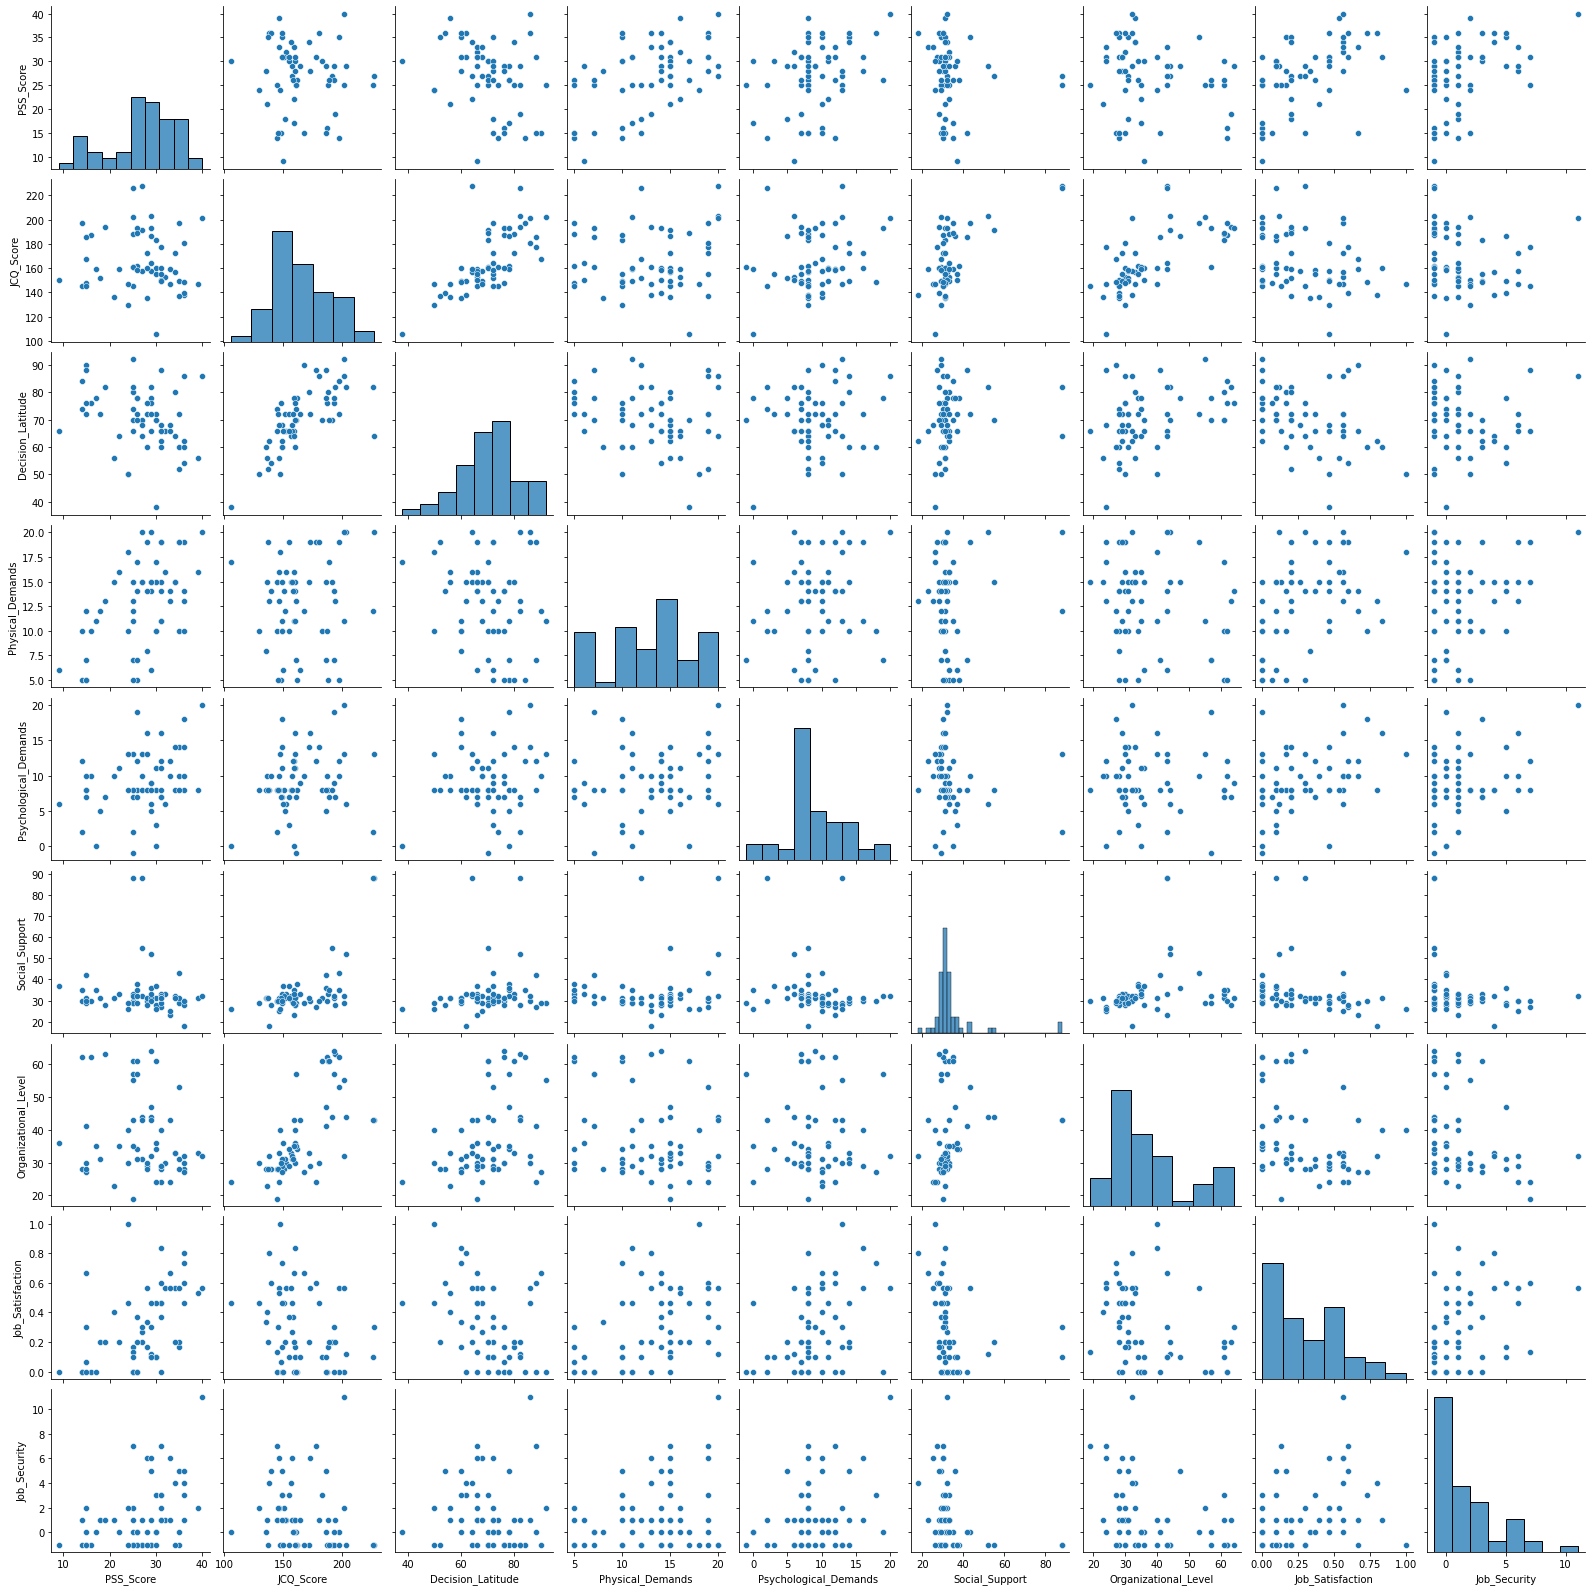

In [46]:
# Make a pairplot of the data
sns.pairplot(psy_df)

## 3. Preprocessing & Feature Selection

In [47]:
df['BMI'].value_counts()

31.308999    2
28.319092    2
27.464398    1
25.821855    1
23.869161    1
26.466251    1
36.145994    1
31.164402    1
33.666037    1
27.703134    1
36.273136    1
25.682792    1
29.626951    1
38.169204    1
31.098790    1
36.106746    1
29.527027    1
22.955102    1
34.942012    1
38.768994    1
26.335068    1
20.843310    1
21.298285    1
24.389796    1
22.462722    1
26.873766    1
26.790174    1
33.670082    1
39.675485    1
28.342400    1
30.724246    1
19.004109    1
26.959459    1
31.190201    1
42.126754    1
36.900635    1
31.580078    1
21.284602    1
28.744889    1
27.016662    1
16.826657    1
25.765818    1
26.578450    1
26.144628    1
31.882086    1
28.147461    1
37.292631    1
27.953609    1
24.126627    1
32.275077    1
21.182432    1
32.277319    1
30.228433    1
28.693878    1
26.622856    1
24.797178    1
26.774414    1
23.078283    1
Name: BMI, dtype: int64

In [48]:
bins = [0, 25, 30, np.inf]
labels = ['Normal', 'Overweight', 'Obese']
df['BMI_cat'] = pd.cut(df['BMI'], bins, labels=labels)

In [49]:
df['BMI_cat'].value_counts()

Overweight    24
Obese         23
Normal        13
Name: BMI_cat, dtype: int64

In [50]:
df['Physical_activity'].value_counts()

1    27
3    13
4    11
5     4
6     3
2     2
Name: Physical_activity, dtype: int64

In [51]:
bins = [0, 3, 6]
labels = ['No to Low', 'Mod to High']
df['Phy_act_cat'] = pd.cut(df['Physical_activity'], bins, labels=labels)

In [52]:
df['Phy_act_cat'].value_counts()

No to Low      42
Mod to High    18
Name: Phy_act_cat, dtype: int64

In [53]:
df['Alcohol'].value_counts()

1    27
2    21
3    12
Name: Alcohol, dtype: int64

In [54]:
bins = [0, 1, 3]
labels = ['No', 'Yes']
df['Alcohol_cat'] = pd.cut(df['Alcohol'], bins, labels=labels)

In [55]:
df['Alcohol_cat'].value_counts()

Yes    33
No     27
Name: Alcohol_cat, dtype: int64

In [56]:
df['Smoking'].value_counts()

1    42
3     9
2     5
4     3
5     1
Name: Smoking, dtype: int64

In [57]:
bins = [0, 1, 5]
labels = ['No', 'Yes']
df['Smoking_cat'] = pd.cut(df['Smoking'], bins, labels=labels)

In [58]:
df['Smoking_cat'].value_counts()

No     42
Yes    18
Name: Smoking_cat, dtype: int64

In [59]:
df['Posture'].value_counts()

5     14
8      9
9      9
4      8
6      7
7      7
3      4
10     2
Name: Posture, dtype: int64

In [60]:
bins = [0, 5, 10]
labels = ['close to neutral', 'non-neutral']
df['Posture_cat'] = pd.cut(df['Posture'], bins, labels=labels)

In [61]:
df['Posture_cat'].value_counts()

non-neutral         34
close to neutral    26
Name: Posture_cat, dtype: int64

In [62]:
df['Force'].value_counts()

0    13
5    13
6    12
4     9
1     4
2     4
3     3
7     2
Name: Force, dtype: int64

In [63]:
bins = [-np.inf, 4, 7]
labels = ['low', 'high']
df['Force_cat'] = pd.cut(df['Force'], bins, labels=labels)

In [64]:
df['Force_cat'].value_counts()

low     33
high    27
Name: Force_cat, dtype: int64

In [65]:
df['Repetition'].value_counts()

0    34
4    10
5     6
3     5
2     3
6     1
7     1
Name: Repetition, dtype: int64

In [66]:
bins = [-np.inf, 1, 7]
labels = ['No', 'Yes']
df['Rep_cat'] = pd.cut(df['Repetition'], bins, labels=labels)

In [67]:
df['Rep_cat'].value_counts()

No     34
Yes    26
Name: Rep_cat, dtype: int64

In [68]:
df['Vibration'].value_counts()

0    47
3     4
4     4
5     3
2     2
Name: Vibration, dtype: int64

In [69]:
bins = [-np.inf, 1, 5]
labels = ['No', 'Yes']
df['Vib_cat'] = pd.cut(df['Vibration'], bins, labels=labels)

In [70]:
df['Vib_cat'].value_counts()

No     47
Yes    13
Name: Vib_cat, dtype: int64

In [ ]:
df['Hours/day'].value_counts()

In [ ]:
bins = [0, 8, np.inf]
labels = ['Low', 'High']
df['Hours_cat'] = pd.cut(df['Hours/day'], bins, labels=labels)

In [71]:
df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [72]:
bins = [0, 20, 60, np.inf]
labels = ['0', '1', '2']
df['ODI'] = pd.cut(df['ODI_Score'], bins, labels=labels)

In [73]:
bins = [0, 40, np.inf]
labels = ['0', '1']
df['ODI2'] = pd.cut(df['ODI_Score'], bins, labels=labels)

In [74]:
df['ODI'].value_counts()

1    47
2     9
0     4
Name: ODI, dtype: int64

In [75]:
df['ODI2'].value_counts()

0    34
1    26
Name: ODI2, dtype: int64

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 60 non-null     object  
 1   Age                    60 non-null     int64   
 2   Height                 60 non-null     int64   
 3   Weight                 60 non-null     int64   
 4   BMI                    60 non-null     float64 
 5   Ethnicity              60 non-null     object  
 6   History                60 non-null     object  
 7   Physical_activity      60 non-null     int64   
 8   Alcohol                60 non-null     int64   
 9   Smoking                60 non-null     int64   
 10  Hours/day              60 non-null     object  
 11  Years                  60 non-null     float64 
 12  Occ_Score              60 non-null     int64   
 13  Posture                60 non-null     int64   
 14  Force                  60 non-null     int64

In [77]:
df['ODI'] = df['ODI'].astype(int)

In [78]:
df['ODI2'] = df['ODI2'].astype(int)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 60 non-null     object  
 1   Age                    60 non-null     int64   
 2   Height                 60 non-null     int64   
 3   Weight                 60 non-null     int64   
 4   BMI                    60 non-null     float64 
 5   Ethnicity              60 non-null     object  
 6   History                60 non-null     object  
 7   Physical_activity      60 non-null     int64   
 8   Alcohol                60 non-null     int64   
 9   Smoking                60 non-null     int64   
 10  Hours/day              60 non-null     object  
 11  Years                  60 non-null     float64 
 12  Occ_Score              60 non-null     int64   
 13  Posture                60 non-null     int64   
 14  Force                  60 non-null     int64

In [81]:
#Drop features
columns_to_drop=['ODI_Score', 'VAS', 'ODI2']
dff=df.drop(columns=columns_to_drop)

columns_to_drop2=['ODI_Score', 'VAS', 'ODI']
dff2=df.drop(columns=columns_to_drop2)

In [82]:
dff.shape

(60, 35)

In [83]:
dff2.shape

(60, 35)

In [85]:
#one hot encoding
df_encoded =pd.get_dummies(dff, columns=['Gender','History','Ethnicity', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat'])
df_encoded2 =pd.get_dummies(dff2, columns=['Gender','History','Ethnicity', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat'])

In [86]:
df_encoded.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'Physical_activity', 'Alcohol',
       'Smoking', 'Hours/day', 'Years', 'Occ_Score', 'Posture', 'Force',
       'Repetition', 'Vibration', 'PSS_Score', 'JCQ_Score',
       'Decision_Latitude', 'Physical_Demands', 'Psychological_Demands',
       'Social_Support', 'Organizational_Level', 'Job_Satisfaction',
       'Job_Security', 'ODI', 'Gender_F', 'Gender_M', 'History_No',
       'History_Yes', 'Ethnicity_Black', 'Ethnicity_Caucasian',
       'Ethnicity_Other', 'BMI_cat_Normal', 'BMI_cat_Overweight',
       'BMI_cat_Obese', 'Phy_act_cat_No to Low', 'Phy_act_cat_Mod to High',
       'Alcohol_cat_No', 'Alcohol_cat_Yes', 'Smoking_cat_No',
       'Smoking_cat_Yes', 'Posture_cat_close to neutral',
       'Posture_cat_non-neutral', 'Force_cat_low', 'Force_cat_high',
       'Rep_cat_No', 'Rep_cat_Yes', 'Vib_cat_No', 'Vib_cat_Yes'],
      dtype='object')

In [87]:
df_encoded2.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'Physical_activity', 'Alcohol',
       'Smoking', 'Hours/day', 'Years', 'Occ_Score', 'Posture', 'Force',
       'Repetition', 'Vibration', 'PSS_Score', 'JCQ_Score',
       'Decision_Latitude', 'Physical_Demands', 'Psychological_Demands',
       'Social_Support', 'Organizational_Level', 'Job_Satisfaction',
       'Job_Security', 'ODI2', 'Gender_F', 'Gender_M', 'History_No',
       'History_Yes', 'Ethnicity_Black', 'Ethnicity_Caucasian',
       'Ethnicity_Other', 'BMI_cat_Normal', 'BMI_cat_Overweight',
       'BMI_cat_Obese', 'Phy_act_cat_No to Low', 'Phy_act_cat_Mod to High',
       'Alcohol_cat_No', 'Alcohol_cat_Yes', 'Smoking_cat_No',
       'Smoking_cat_Yes', 'Posture_cat_close to neutral',
       'Posture_cat_non-neutral', 'Force_cat_low', 'Force_cat_high',
       'Rep_cat_No', 'Rep_cat_Yes', 'Vib_cat_No', 'Vib_cat_Yes'],
      dtype='object')

In [88]:
df_encoded.shape

(60, 48)

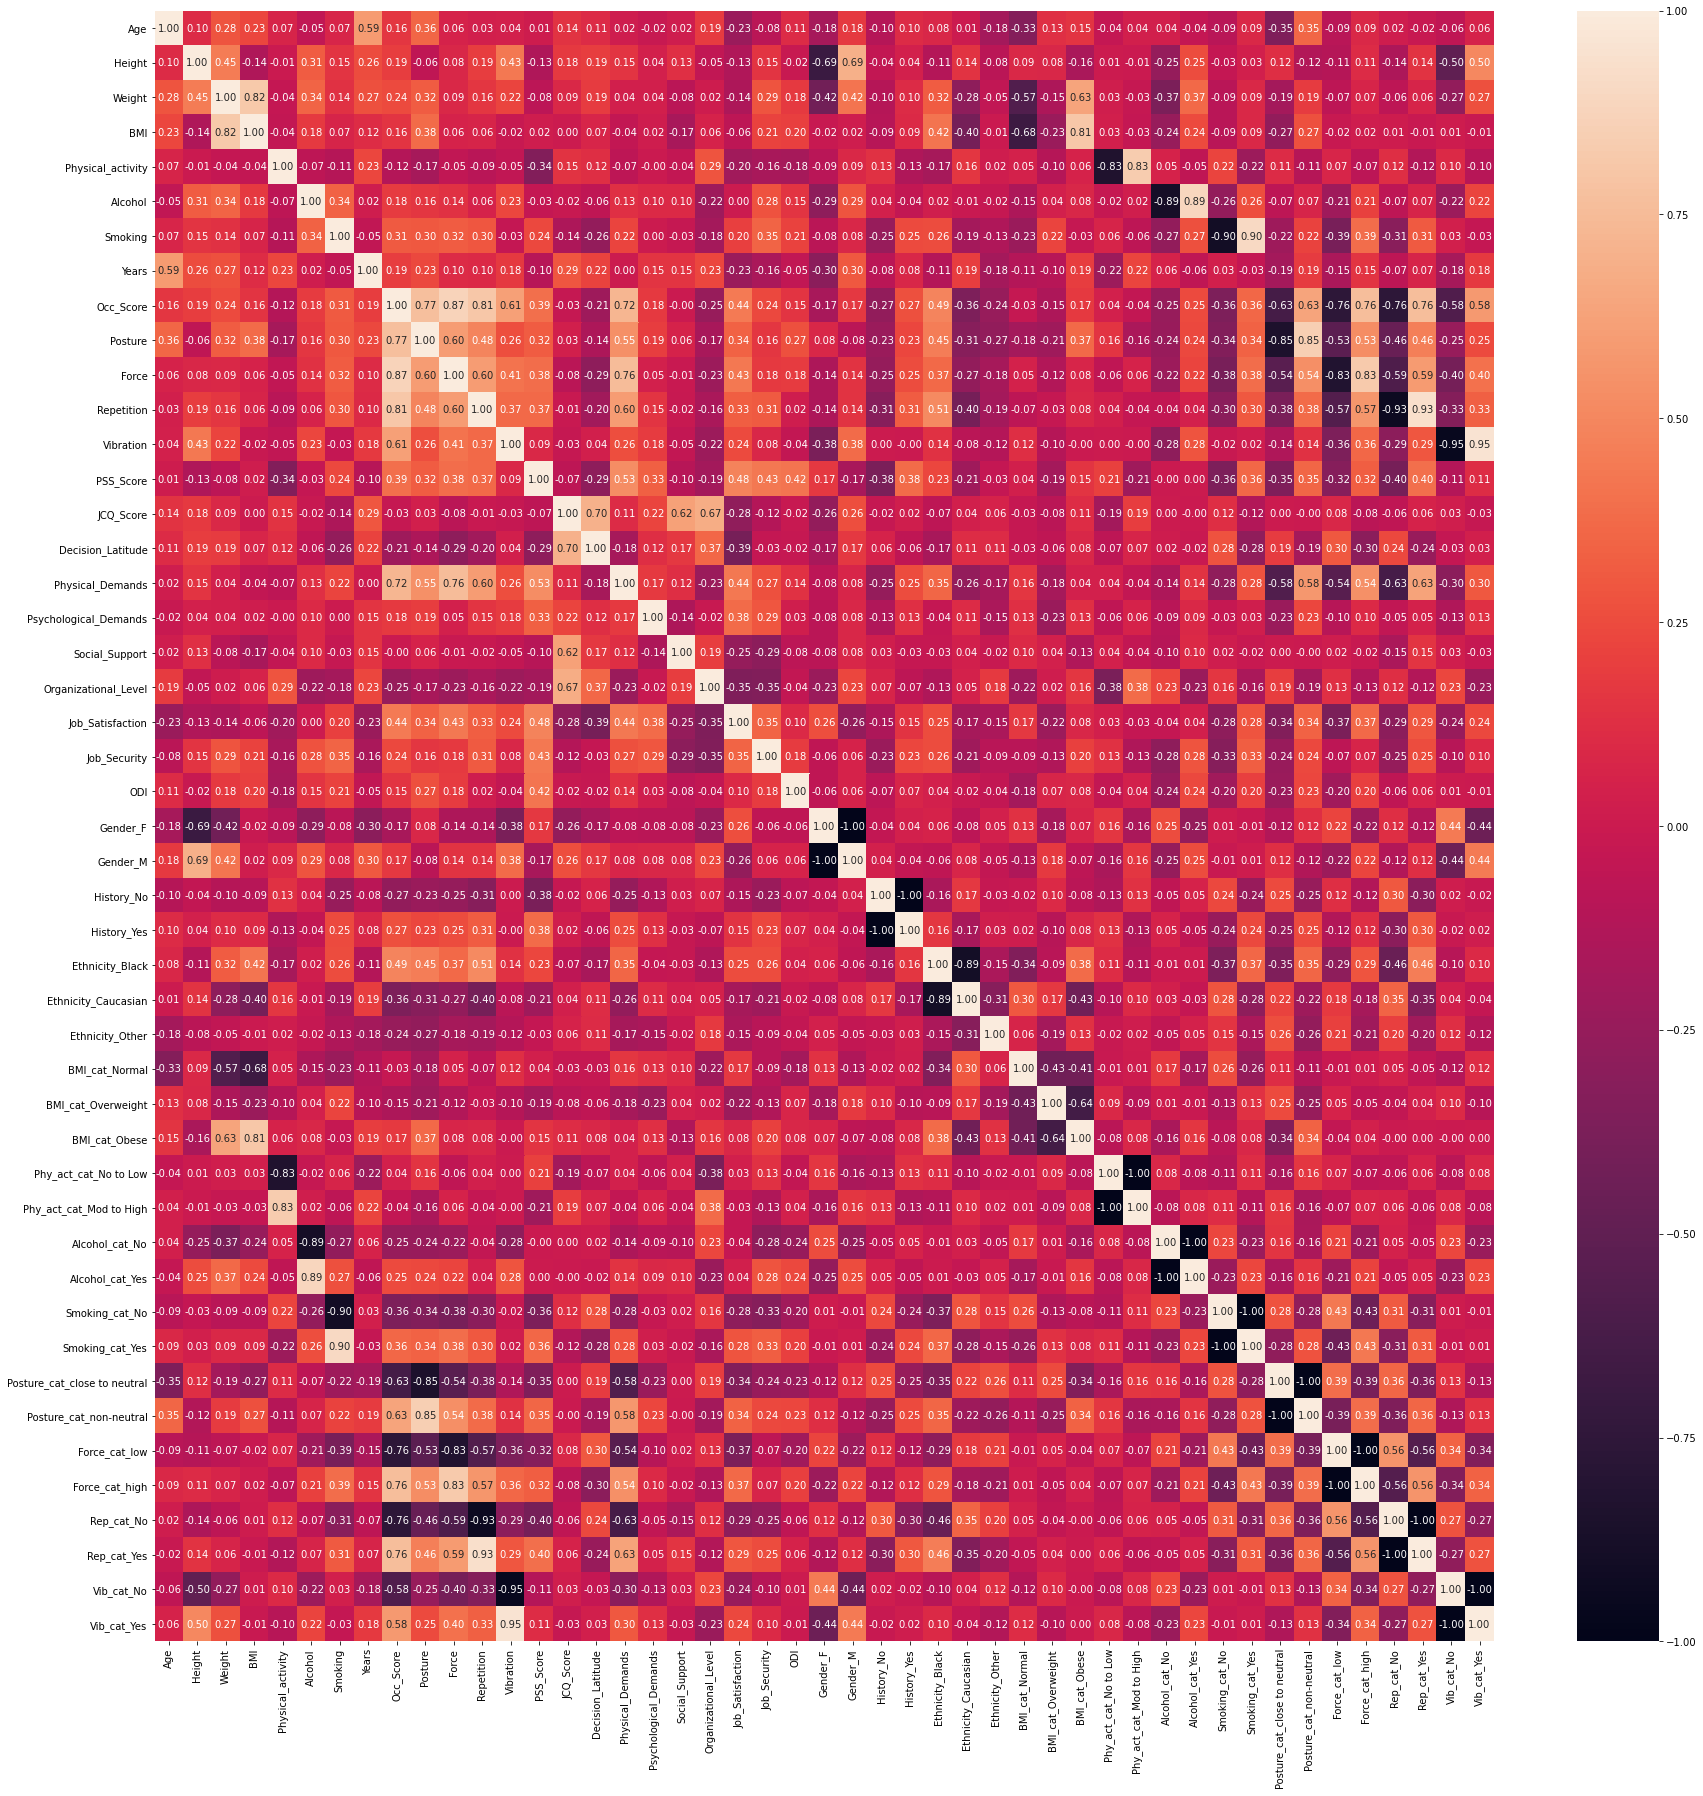

In [89]:
#Visualize correlation of target with other feathures
plt.subplots(figsize=(30,30))

corr = df_encoded.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

### Regression

In [91]:
#Drop categorical variables
names_list = ['Ethnicity', 'Gender', 'History', 'BMI_cat', 'Phy_act_cat', 'Alcohol_cat', 'Smoking_cat', 'Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat', 'ODI', 'ODI2', 'VAS', 'Hours/day', 'Years']
dff3=df.drop(columns=names_list)

In [92]:
dff3.shape

(60, 22)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(dff3.drop(columns='ODI_Score'), 
                                                    dff3.ODI_Score, test_size=0.3, 
                                                    random_state=47)

In [94]:
X_train.shape, X_test.shape

((42, 21), (18, 21))

In [95]:
y_train.shape, y_test.shape

((42,), (18,))

In [96]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Age                        int64
Height                     int64
Weight                     int64
BMI                      float64
Physical_activity          int64
Alcohol                    int64
Smoking                    int64
Occ_Score                  int64
Posture                    int64
Force                      int64
Repetition                 int64
Vibration                  int64
PSS_Score                  int64
JCQ_Score                float64
Decision_Latitude          int64
Physical_Demands           int64
Psychological_Demands      int64
Social_Support             int64
Organizational_Level       int64
Job_Satisfaction         float64
Job_Security               int64
dtype: object

In [97]:
X_test.dtypes

Age                        int64
Height                     int64
Weight                     int64
BMI                      float64
Physical_activity          int64
Alcohol                    int64
Smoking                    int64
Occ_Score                  int64
Posture                    int64
Force                      int64
Repetition                 int64
Vibration                  int64
PSS_Score                  int64
JCQ_Score                float64
Decision_Latitude          int64
Physical_Demands           int64
Psychological_Demands      int64
Social_Support             int64
Organizational_Level       int64
Job_Satisfaction         float64
Job_Security               int64
dtype: object

In [98]:
pipe = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [99]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fa10e47c1f0>)),
                ('linearregression', LinearRegression())])

In [100]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [101]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.4848801407773706, 0.13142155393650312)

In [102]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.358325166247283, 11.204430324477165)

In [103]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [104]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [105]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fa10e47c1f0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21]})

In [106]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [107]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 7}

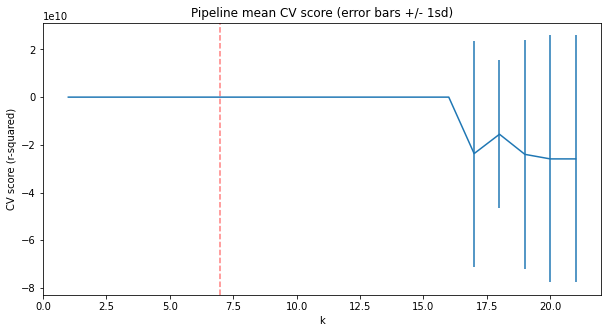

In [108]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [109]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [110]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

PSS_Score       6.070636
Alcohol         5.007422
Age             3.969259
Posture         2.837253
Smoking         2.433395
Job_Security   -0.036940
Force          -1.616296
dtype: float64

In [111]:
#Random Forest Model
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [112]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [113]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-6.725945  ,  0.01865248, -0.15265018,  0.05577577,  0.09913957])

In [114]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-1.3410054732709744, 2.693824319770802)

In [115]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [116]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [117]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [118]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 379, 'standardscaler': None}

In [119]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-5.27212808e+00,  2.43138119e-02, -9.83835901e-02,  6.35292311e-02,
       -1.16084562e-03])

In [120]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-1.0567658951850913, 2.1083582021388794)

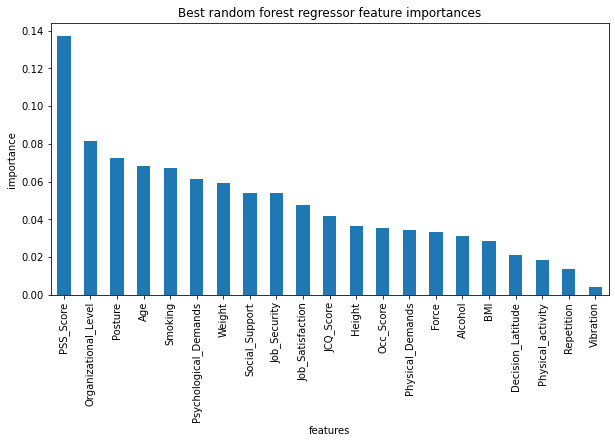

In [121]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [122]:
#Linear regression model performance
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [123]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(11.139541247032062, 2.3090993225091956)

In [124]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

9.704852822231553

In [125]:
mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test), squared=False)

12.667015557371998

In [126]:
#Random forest regression model performance
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [127]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(12.971430665493989, 1.768347724295624)

In [128]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

10.949574904720022

In [129]:
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test), squared=False)

12.454641176497717

In [130]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

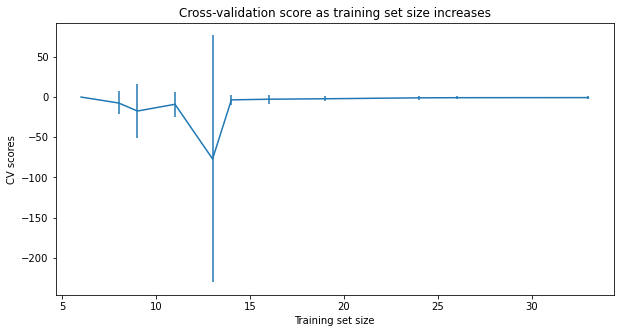

In [131]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 4. Modelling

### Regression

In [132]:
X = dff3.drop(columns='ODI_Score')
y = dff3.ODI_Score

In [133]:
len(X), len(y)

(60, 60)

In [134]:
rf_grid_cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [135]:
cv_results = cross_validate(rf_grid_cv, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [136]:
cv_results['test_score']

array([-20.73611111, -10.76655443,  -9.40909091,  -9.82692308,
       -13.82539683])

In [137]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(12.912815271148606, 4.20575827923595)

In [138]:
mean_squared_error(y, rf_grid_cv.predict(X), squared=False)

5.628442274744328

In [139]:
mean_squared_error(y, rf_grid_cv.predict(X))

31.679362440129108